In [1]:
!pip -q install roboflow
!pip -q install ultralytics
! pip -q install ruamel.yaml
! wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt

from roboflow import Roboflow
import sys
import ruamel.yaml
from ultralytics import YOLO
from pathlib import Path
import os
from collections import defaultdict
import copy
import math
import shutil
import numpy as np
import psutil
import gc
import matplotlib.pyplot as plt
import locale
from IPython.display import clear_output
import ctypes
import ctypes.util
import torch
import random


# deterministic set
torch.manual_seed(43)
random.seed(43)
np.random.seed(43)

rf = Roboflow(api_key="tD9RSesaXxGqmwVD6eVZ")
project = rf.workspace("roboarm").project("feet-qevah")
dataset = project.version(10).download("yolov8")


%cd /kaggle/working/feet-10

gc.enable()

libc = ctypes.CDLL(ctypes.util.find_library('c'))
libc.malloc_trim(ctypes.c_int(0))

torch.set_num_threads(1)
os.environ["OMP_NUM_THREADS"] = "1"


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pytoolconfig 1.2.5 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.
--2023-10-31 18:53:13--  https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/521807533/a67767a2-6acf-4b1b-9d2a-2836e18fbcfd?X-Amz-Algorithm=AWS4-HMAC-SH

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.203, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to feet-10 in yolov8:: 100%|██████████| 10526/10526 [00:02<00:00, 4452.43it/s]


/kaggle/working/feet-10


In [2]:
class YoloModel:
    def __init__(self, path_to_model: str, path_to_yaml: str,
                 train_perc: float, test_perc: float, val_perc: float,
                 ttvs_flag = 0, tp_flag = 0):
        """Инициализация переменных

        Args:
            path_to_model (str): путь до весов yolov8.pt
            path_to_yaml (str): путь до data.yaml файла датасета
            train_perc (float): доля тренировочных данных 
            test_perc (float): доля тестовых данных
            val_perc (float): доля валидационных данных
        """        
        self.path_to_model = path_to_model
        self.path_to_yaml = path_to_yaml
        self.train_path = Path('train') if os.path.exists(Path('train')) else None
        self.test_path = Path('test') if os.path.exists(Path('test')) else None
        self.val_path = Path('valid') if os.path.exists(Path('valid')) else None
        self.train_perc = train_perc
        self.test_perc = test_perc
        self.val_perc = val_perc
        
        self.ttvs_flag = ttvs_flag
        self.tp_flag = tp_flag
        
        self.ram_usage = []
        
        assert self.train_path != None, 'Директория train отсутствует'
        if (self.val_path == None):
            os.mkdir("valid", mode=0o777)
            os.mkdir("valid/images", mode=0o777)
            os.mkdir("valid/labels", mode=0o777)
            self.val_path = Path("valid")
        if (self.test_path == None):
            os.mkdir("test", mode=0o777)
            os.mkdir("test/images", mode=0o777)
            os.mkdir("test/labels", mode=0o777)
            self.test_path = Path("test")
    
    def get_ram_usage(self,):
        """Gets the current RAM usage of the system.

        Returns:
            float: RAM usage in GB.
        """
        return psutil.virtual_memory().used / 1e9

    def train(self, folder_name: str, iters: int) -> YOLO: 
        """Инициализация модели и обучение

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        # yaml.preserve_quotes = True
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = './'+folder_name+'/train/images'
                elif elem == 'val':
                    data[elem] = './'+folder_name+'/valid/images'
                elif elem == 'test':
                    data[elem] = './temp/images'
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        self.ram_usage.append(self.get_ram_usage())
        model = YOLO(self.path_to_model)
        model.train(
            # Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def retrain(self, folder_name: str, iters: int,) -> YOLO:
        """Обучение модели на всех предыдущих частях данных для профилакти просадки метрики

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        os.mkdir("retrain", mode=0o777)
        os.mkdir("retrain/train", mode=0o777)
        os.mkdir("retrain/valid", mode=0o777)
        os.mkdir("retrain/train/images", mode=0o777)
        os.mkdir("retrain/train/labels", mode=0o777)
        os.mkdir("retrain/valid/images", mode=0o777)
        os.mkdir("retrain/valid/labels", mode=0o777)

        # собираем список всех кусков данных до нашего folder_name
        folder_num = np.arange(1, int(folder_name.split('_')[-1]) + 1)
        source_pathes = [f"temp_{i}" for i in folder_num]

        # копируем все собранные куски данных в папку retrain
        for path in source_pathes:
            # собираем все файлы
            all_images_train = os.listdir(path+"/train/images")
            all_labels_train = os.listdir(path+"/train/labels")

            all_images_valid = os.listdir(path+"/valid/images")
            all_labels_valid = os.listdir(path+"/valid/labels")

            for image in all_images_train:
                shutil.copyfile(path+"/train/images/" + image,
                                "retrain/train/images/" + image)
            for label in all_labels_train:
                shutil.copyfile(path+"/train/labels/" + label,
                                "retrain/train/labels/" + label)
            for image in all_images_valid:
                shutil.copyfile(path+"/valid/images/" + image,
                                "retrain/valid/images/" + image)
            for label in all_labels_valid:
                shutil.copyfile(path+"/valid/labels/" + label,
                                "retrain/valid/labels/" + label)

        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = 'retrain/valid/images'
                elif elem == 'test':
                    data[elem] = './temp/images'
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        
        self.ram_usage.append(self.get_ram_usage())
        # load a pretrained model (recommended for training)
        model = YOLO(self.path_to_model)
        model.train(# Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def test(self, model: YOLO):
        """Тестирование модели

        Args:
            model (YOLO): экземпляр обученной модели

        Returns:
            _type_: _description_
        """        
        metrics = model.val(data=self.path_to_yaml, split="test")
        return metrics
    
    def train_test_val_split(self, keep_perc: float):
        """Разделение изначального датасета на заданные доли train/test/val. Удаление 1-keep_perc доли данных 

        Args:
            keep_perc (float): доля данных, которую нужно оставить
        """        
        # создаем директории для объединения всех файлов
        os.mkdir("temp", mode=0o777)
        os.mkdir("temp/images", mode=0o777)
        os.mkdir("temp/labels", mode=0o777)
            
        source_pathes = (self.train_path / 'images', self.train_path / 'labels',\
                        self.test_path / 'images', self.test_path / 'labels',\
                        self.val_path / 'images', self.val_path / 'labels',)
        destination = Path('temp')

        for path in source_pathes:
            # собираем все файлы
            allfiles = os.listdir(path)
            # итерируем по всем файлам, чтобы переместить их в папку назначения
            sub_folder = path.name # images or labels
            for f in allfiles:
                src_path = os.path.join(path, f)
                dst_path = os.path.join(destination / sub_folder, f)
                os.rename(src_path, dst_path)
        total_num = len(allfiles)
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("temp/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
        print(f"Кол-во пустых файлов - {empty_count}")
        # Оставляем указанный процент данных
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(pathes)
            num_to_del = num_files*(1-keep_perc)
            for i, file_path in enumerate(pathes.copy()):
                if i+1 >= num_to_del:
                    break
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                try:
                    Path("temp",'images',".".join(f)).unlink()
                    file_path.unlink()
                except OSError as e:
                    # Файл не найден (скорее всего имеет несколько классов и был уже перемещен)
                    pass
                classes[cls].remove(file_path)

        # Распределяем данные по директориям train, test, val с учетом указанных пропорций
        class_copy = copy.deepcopy(classes)
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(class_copy[cls])
            num_to_mv_train = int(num_files * self.train_perc)
            num_to_mv_test = int(num_files * self.test_perc)
            num_to_mv_val = int(num_files * self.val_perc)
            # print(num_files, num_to_mv, len(pathes))
            temp_dict_name = "train"
            for i, file_path in enumerate(pathes.copy()):
                if i+1 > num_to_mv_train and i+1 < num_to_mv_val + num_to_mv_train:
                    temp_dict_name = "valid"
                elif i+1 > num_to_mv_val + num_to_mv_train:
                    temp_dict_name = "test"
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                try:
                    os.replace(Path("temp","images",".".join(f)), Path(temp_dict_name,"images").joinpath(Path("temp","images",".".join(f)).name))
                    os.replace(file_path, Path(temp_dict_name,"labels").joinpath(file_path.name))
                except OSError as e:
                    # Файл не найден (скорее всего имеет несколько классов и был уже перемещен)
                    pass
                classes[cls].remove(file_path)
        shutil.rmtree("temp")

    def take_piece(self, piece_perc: float):
        """Разделение исходного датасета на части равные доле piece_perc по директориям temp_{n}, n = {1..1/piece_perc}

        Args:
            piece_perc (float): доля части данных, на которые нужно поделить датасет
        """        
        # создаем директории для объединения всех файлов
        os.mkdir("temp", mode=0o777)
        os.mkdir("temp/images", mode=0o777)
        os.mkdir("temp/labels", mode=0o777)

        source_pathes = (self.train_path / 'images', self.train_path / 'labels',
                        self.test_path / 'images', self.test_path / 'labels',
                        self.val_path / 'images', self.val_path / 'labels',)
        destination = Path('temp')

        for path in source_pathes:
            # собираем все файлы
            allfiles = os.listdir(path)
            # итерируем по всем файлам, чтобы переместить их в папку назначения
            sub_folder = path.name  # images or labels
            for f in allfiles:
                src_path = os.path.join(path, f)
                dst_path = os.path.join(destination / sub_folder, f)
                os.rename(src_path, dst_path)
        total_num = len(allfiles)
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("temp/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
        print(f"Кол-во пустых файлов - {empty_count}")
        self.num_folders = 1 / piece_perc
        for folder in range(int(self.num_folders)):
            os.mkdir(f"temp_{folder+1}", mode=0o777)

            os.mkdir(f"temp_{folder+1}/train", mode=0o777)
            os.mkdir(f"temp_{folder+1}/valid", mode=0o777)

            os.mkdir(f"temp_{folder+1}/train/labels", mode=0o777)
            os.mkdir(f"temp_{folder+1}/train/images", mode=0o777)
            os.mkdir(f"temp_{folder+1}/valid/labels", mode=0o777)
            os.mkdir(f"temp_{folder+1}/valid/images", mode=0o777)
        # Распределяем данные по директориям train, test, val с учетом указанных пропорций
        class_copy = copy.deepcopy(classes)
        for folder in range(int(self.num_folders)):
            folder_name = f"temp_{folder+1}"
            for cls, pathes in zip(list(classes.keys()), list(classes.values())):
                num_files = len(class_copy[cls])
                num_to_mv_train = int(num_files * self.train_perc * piece_perc)
                num_to_mv_val = int(num_files * self.val_perc * piece_perc)
                # print(num_files, num_to_mv, len(pathes))
                temp_dict_name = "train"
                for i, file_path in enumerate(pathes.copy()):
                    if i+1 > num_to_mv_train and i+1 < num_to_mv_val + num_to_mv_train:
                        temp_dict_name = "valid"
                    if i+1 >= num_to_mv_val + num_to_mv_train + 3:  # останавливаем только если это последняя папка
                        break
                    f = file_path.name.split('.')[:-1]
                    f.append('jpg')
                    try:
                        os.replace(Path("temp", "images", ".".join(f)), Path(
                            folder_name, temp_dict_name, "images").joinpath(Path("temp", "images", ".".join(f)).name))
                        os.replace(file_path, Path(
                            folder_name, temp_dict_name, "labels").joinpath(file_path.name))
                    except OSError as e:
                        # Файл не найден (скорее всего имеет несколько классов и был уже перемещен)
                        pass
                    classes[cls].remove(file_path)
    
    def plot_result(self, result_dict: dict, color_dict = "green"):
        '''Функция для отрисовки графиков зависимости метрик от размера обучающей выборки

        Args:
            result_dict (dict): словарь с метриками {доля данных: массив метрик}
            color_dict (dict): словарь с индикаторами повторного обучения
        '''
        metrics_names = ("mAP","mAP50", "mAP75")
        colors = list(color_dict.values()) if color_dict != 'green' else color_dict
        for i, metric in enumerate(metrics_names):
            plt.scatter(list(result_dict.keys()), [j[i] for j in result_dict.values()], color=colors, zorder=1)
            plt.plot(list(result_dict.keys()), [j[i] for j in result_dict.values()], linestyle='-')
            plt.ylabel(metric)
            plt.xlabel("Keep percent (%)")
            plt.show()
        
    def plot_ram_usage(self,):
        '''Функция для отрисовки использования RAM в процессе обучения'''
        plt.plot(self.ram_usage, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('RAM Usage (GB)')
        plt.title('RAM Usage During Training')
        plt.show()
    
    def increm_learning(self, keep_perc: float, piece_perc: float, iters: int):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            self.take_piece(piece_perc)
            self.tp = 1
        else:
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        result_dict = {k_p:[] for k_p in range(int(self.num_folders))}
        # словарь с индикаторами повторного обучения
        color_dict = defaultdict(str)
        # переменная для отслеживания максимального map в целях профилактики просадок метрики
        max_map = 0
        
        # Инкрементальное обучение 
        for folder in range(int(self.num_folders)):
            libc = ctypes.CDLL(ctypes.util.find_library('c'))
            libc.malloc_trim(ctypes.c_int(0))

            torch.set_num_threads(1)
            folder_name = f"temp_{folder+1}"
            # дообучаем модель
            model = self.train(folder_name, iters)
            # тестируем модель
            metrics = self.test(model)
            # проверяем, что метрика улучшается
            if metrics.seg.map > max_map:
                max_map = metrics.seg.map
                # заносим метрики в словарь
                result_dict[folder].append(metrics.seg.map)
                result_dict[folder].append(metrics.seg.map50)
                result_dict[folder].append(metrics.seg.map75)
                color_dict[folder] = "green"
                clear_output(wait=True)
                del(model)
                del(metrics)
                gc.collect()
                self.path_to_model = "./runs/segment/train/weights/last.pt"
            else:
                self.path_to_model = native_path_to_model
                # дообучаем модель
                model = self.retrain(folder_name, iters)
                # тестируем модель
                metrics = self.test(model)
                if metrics.seg.map > max_map:
                    max_map = metrics.seg.map
                # заносим метрики в словарь
                result_dict[folder].append(metrics.seg.map)
                result_dict[folder].append(metrics.seg.map50)
                result_dict[folder].append(metrics.seg.map75)
                color_dict[folder] = "blue"
                clear_output(wait=True)
                del(model)
                del(metrics)
                gc.collect()
                self.path_to_model = "./runs/segment/train/weights/last.pt"
                shutil.rmtree("retrain")
                
        print(f"Итоговый результат (инкрементальное обучение): \n {result_dict}")
        self.plot_result(result_dict, color_dict)
        
        return result_dict, color_dict

    def base_learning(self, keep_perc: float, piece_perc: float, iters: int):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            self.take_piece(piece_perc)
            self.tp_flag = 1
        else: 
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        result_dict = {k_p:[] for k_p in range(int(self.num_folders))}
        
        for folder in range(int(self.num_folders)):
            folder_name = f"temp_{folder+1}"
            # дообучаем модель
            model = self.retrain(folder_name, iters)
            # тестируем модель
            metrics = self.test(model)
            # заносим метрики в словарь
            result_dict[folder].append(metrics.seg.map)
            result_dict[folder].append(metrics.seg.map50)
            result_dict[folder].append(metrics.seg.map75)
            clear_output(wait=True)
            del(model)
            del(metrics)
            gc.collect()
            shutil.rmtree("retrain")
            
        print(f"Итоговый результат (базовое обучение): \n {result_dict}")
        self.plot_result(result_dict)
        
        return result_dict

Итоговый результат (базовое обучение): 
 {0: [0.6753708577006597, 0.9846323977083637, 0.7315250917608715], 1: [0.7002289164037079, 0.9726215800785456, 0.7801207530450158], 2: [0.7720245136841515, 0.9908166243198178, 0.9014068606532353], 3: [0.7793420755539395, 0.9863633237572446, 0.8993290498272741], 4: [0.7836318260539803, 0.9904828121108031, 0.9190944823934477], 5: [0.7968218140162802, 0.9903974433708009, 0.9350771909640783], 6: [0.8123169985586337, 0.9916983363276158, 0.9352872928622051], 7: [0.807719981545287, 0.9886259445706685, 0.9303235777956409], 8: [0.8000839026438722, 0.9909791654468968, 0.9364701516870393], 9: [0.8099127519580561, 0.9879471737716878, 0.9467939231306652]}


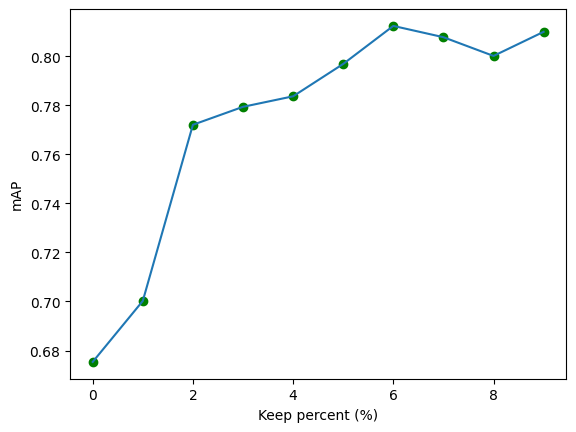

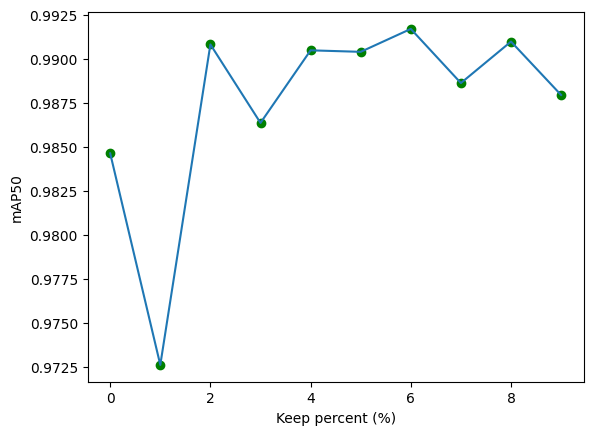

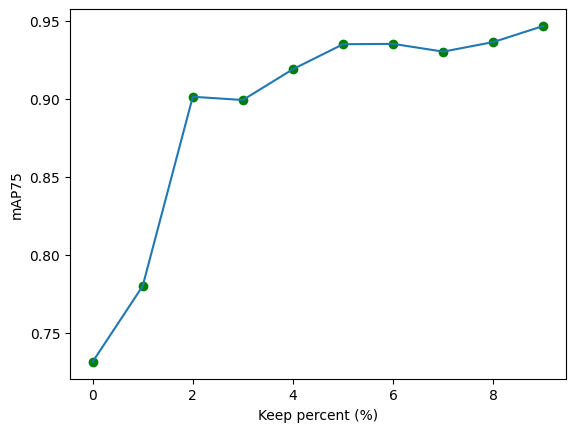

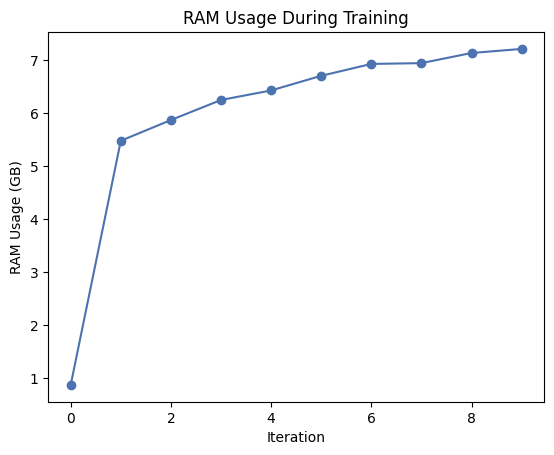

In [3]:
locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/feet-10/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.1
ITERS = 5

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_base = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
result_dict_base = exp_base.base_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_base.plot_ram_usage()
del(exp_base)

Итоговый результат (инкрементальное обучение): 
 {0: [0.6753708577006597, 0.9846323977083637, 0.7315250917608715], 1: [0.6989365633575267, 0.9877496990218859, 0.7728929781791003], 2: [0.7277051333892623, 0.986827087572608, 0.8723643090623733], 3: [0.7819767749750551, 0.9896794597375462, 0.9289476451691747], 4: [0.791557381708831, 0.991368774476066, 0.9183778153470248], 5: [0.7931726225287379, 0.9908784544418667, 0.9305770955911435], 6: [0.8123169985586337, 0.9916983363276158, 0.9352872928622051], 7: [0.8257260231379575, 0.9923871781509097, 0.9560679608063138], 8: [0.8351091360854571, 0.9917535978650327, 0.9606817829084737], 9: [0.8099127519580561, 0.9879471737716878, 0.9467939231306652]}


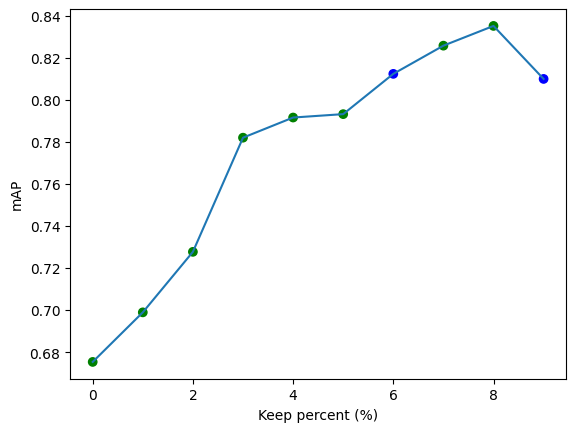

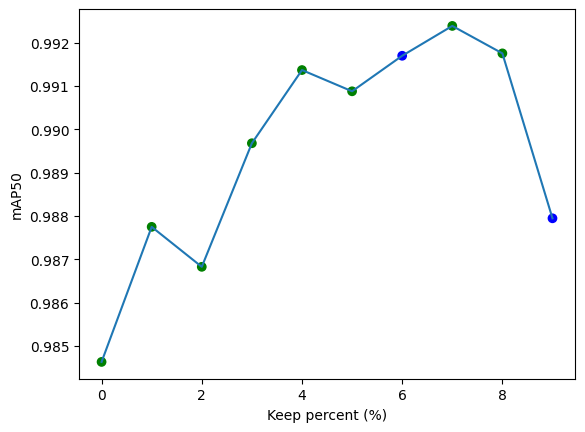

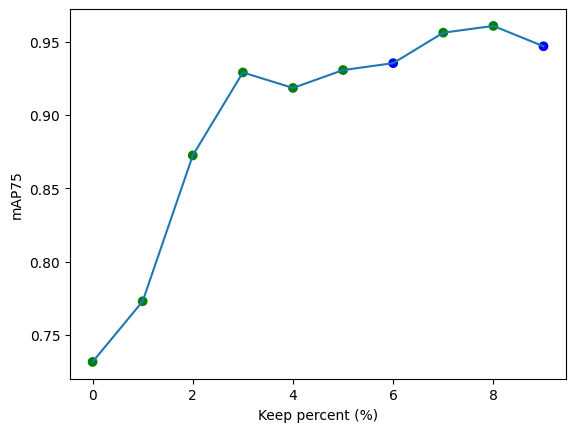

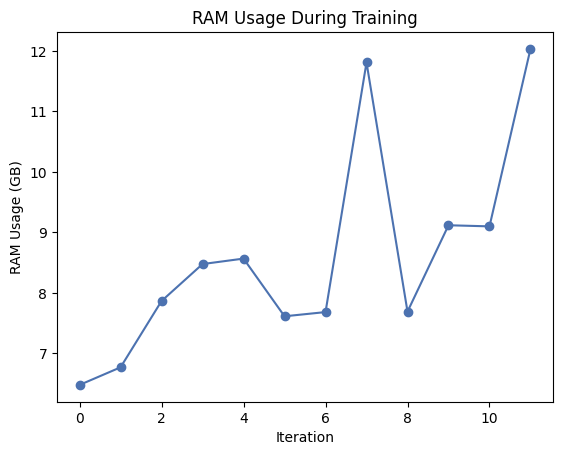

In [4]:
exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC, 1, 1)
result_dict_inc, color_dict_inc = exp_inc.increm_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_inc.plot_ram_usage()

In [5]:
import math 

map_base_list = [j[0] for j in result_dict_base.values()]
map_inc_list = [j[0] for j in result_dict_inc.values()]
mse = 0
for map_base, map_inc in zip(map_base_list, map_inc_list):
    dev = (map_base - map_inc)
    mse += dev**2
print(f"MSE = {mse}\nRMSE = {math.sqrt(mse)}")

MSE = 0.0035999348295839943
RMSE = 0.05999945691074207


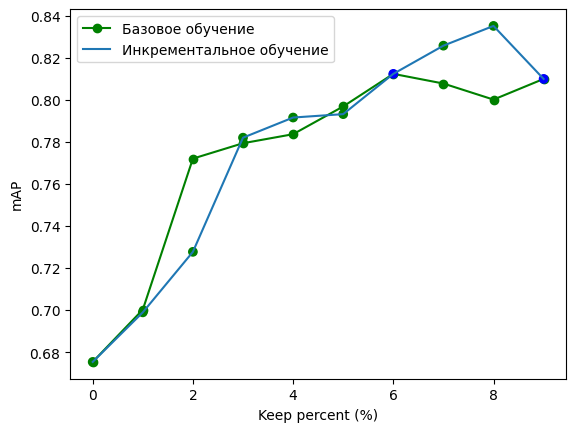

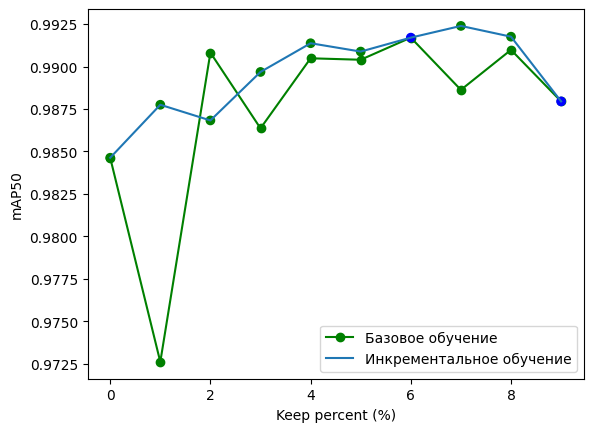

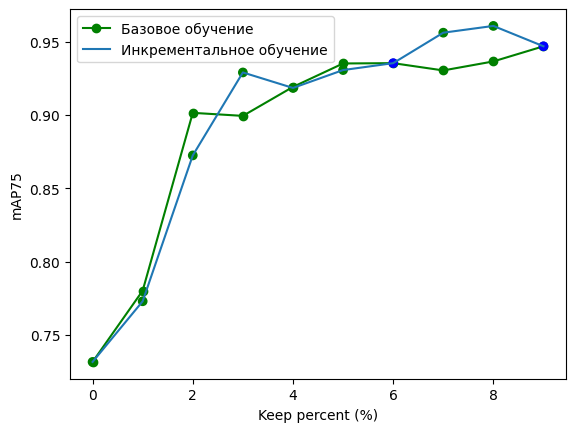

In [6]:
metrics_names = ("mAP","mAP50", "mAP75")
for i, metric in enumerate(metrics_names):
    plt.plot(list(result_dict_base.keys()),
             [j[i] for j in result_dict_base.values()],
             marker='o',
             color="green",
             linestyle='-',
             zorder=0,
             label = "Базовое обучение")
    
    plt.scatter(list(result_dict_inc.keys()),
                [j[i] for j in result_dict_inc.values()],
                color=list(color_dict_inc.values()),
                zorder=1)
    plt.plot(list(result_dict_inc.keys()),
             [j[i] for j in result_dict_inc.values()],
             linestyle='-',
             label = "Инкрементальное обучение")
    
    plt.ylabel(metric)
    plt.xlabel("Keep percent (%)")
    plt.legend()
    plt.show()

In [7]:
num_folders = 1 / PIECE_PERC
for folder in range(int(num_folders)):
    dir_path = f"temp_{folder+1}/train/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/train/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), '\n')
    


temp_1/train/labels 420
temp_1/train/images 420
temp_1/valid/labels 54
temp_1/valid/images 54 

temp_2/train/labels 420
temp_2/train/images 420
temp_2/valid/labels 54
temp_2/valid/images 54 

temp_3/train/labels 420
temp_3/train/images 420
temp_3/valid/labels 54
temp_3/valid/images 54 

temp_4/train/labels 420
temp_4/train/images 420
temp_4/valid/labels 54
temp_4/valid/images 54 

temp_5/train/labels 420
temp_5/train/images 420
temp_5/valid/labels 54
temp_5/valid/images 54 

temp_6/train/labels 420
temp_6/train/images 420
temp_6/valid/labels 54
temp_6/valid/images 54 

temp_7/train/labels 420
temp_7/train/images 420
temp_7/valid/labels 54
temp_7/valid/images 54 

temp_8/train/labels 420
temp_8/train/images 420
temp_8/valid/labels 54
temp_8/valid/images 54 

temp_9/train/labels 420
temp_9/train/images 420
temp_9/valid/labels 54
temp_9/valid/images 54 

temp_10/train/labels 420
temp_10/train/images 420
temp_10/valid/labels 54
temp_10/valid/images 54 

